<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Семинар. RAG

В классических LLM все знания хранятся внутри модели. То есть, если спросить у LLM вопрос вида "какова высота Килиманджаро" или "сколько оскаров было у Ди Каприо", модель должна будет выдать ответ, не обращаясь ни к каким внешним источникам информации. Кажется, это немного нечестно: заставлять модель хранить все-все подобные факты в своих параметрах. От людей, например, мы не
требуем, чтобы они помнили все в голове, мы для поиска подобных фактов часто обращаемся к внешним источникам (например, интернету). Более того, при таком классическом подходе LLM не может отвечать на вопросы, связанные с событиями, случившимися после завершения обучения LLM.

Отсюда возникает идея дать LLM возможность обращаться к внешним источникам информации при генерации ответа. Так LLM сможет точнее отвечать на вопросы про факты и новые события, и ей необязательно будет хранить информацию о них в своих весах.

Идея похода RAG (Retrieval-Augmented Generation) как раз и состоит в том, чтобы дать LLM доступ к внешним источникам информации при генерации ответа. Теперь у нас есть две сущности: LLM и некоторая база знаний, к которой LLM будет обращаться для извлечения нужной информации перед генерацией итогового ответа.

Обычно процесс работы LLM+RAG в целом выглядит так:

- Когда пользователь задает промпт, из него в каком-то виде выделяется информация, которая потом используется как ключ для запроса в базу данных;
- По ключу из базы данных извлекаются N документов и отсортировываются по степени релевантности пользовательскому запросу;
- При генерации ответа LLM использует данные из запроса пользователя и информацию, полученную из базы знаний.

Реализацией подхода RAG мы и займемся в этом семинаре.

## Общая схема RAG

На картинке ниже представлена общая схема RAG:

![](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png)

Подробнее о компонентах:



### 1. Предварительная подготовка (Pre-production)
- База знаний (Knowledge base): Исходные документы (например, книги или Википедия) обрабатываются и делятся на более мелкие части (чанки). Это позволяет более эффективно работать с текстом и улучшает качество извлечения информации.
- Модель векторизации (Embedding model): Каждая часть документа представляется в виде вектора. Эти эбеддинги затем хранятся в виде векторной базы данных для последующего поиска.
- Векторная база данных (Vector database): База данных, которая хранит векторные представления текста таким образом, чтобы семантически близкие вектора индексировались близко (в одном кластере). В качестве метрики близости обычно используют косинусное сходство.

### 2. Сам процесс поиска и генерации (In production)
#### Шаг 1: Ретривер (Retriever)
- Пользовательский запрос: Пользователь вводит запрос, который может быть отформатирован или переформулирован для лучшего поиска.
- Векторизация пользовательского запроса: Запрос преобразуется в вектор с помощью той же модели, что и для документов.
- Поиск ближайших документов: С использованием векторной базы данных система находит K наиболее схожих документов по вектору пользовательского запроса. Это позволяет быстро извлекать релевантную информацию.

#### Шаг 2: Ридер (Reader)
- Контекст: Извлеченные документы обрабатываются и агрегируются в контекст, который будет использован для генерации ответа. Это может включать сжатие текста или перефразирование.
- Генерация ответа: На основе пользовательского запроса и контекста создается запрос для LLM. Модель генерирует ответ, используя извлеченные данные для повышения точности и релевантности.
- Проверка генерации: Возможно, на этом этапе ответ проверяется на соответствие или корректность.

Реализовать компоненты этого процесса (саму базу знаний, выделение информации из промпта, оценку релевантности документов в базе данных, процесс генерации ответа LLM на основе документов) можно по-разному. В этом семинаре в качестве базы знаний мы будем использовать векторную базу FAISS, а для реализации RAG используем фреймворк LangChain + HF (HuggingFace).

**LangChain** — это популярный и очень удобный феймфорк для создания приложений на основе LLM. RAG — один из примеров такого приложени. В нашем случае LangChain поможет нам в следующих вещах:
- С логикой разбиения документов из базы знаний на части (они называются chunks). Документы в нашей базе знаний — это длинные тексты. Их разбивают на части для двух целей: чтобы каждая часть влезала в длину контекста нашей модели, и чтобы каждая часть содержала отдельную смысловую единицу. Имея в базе такие небольшие части информации с конкретной семантикой нам будет проще под каждый конкретный пользовательский запрос искать в базе те части, которые релевантны под этот запрос.
- С ранжированием полученных из базы знаний документов по релевантности запросу;
- <...>

## Установка и импорт нужных библиотек

In [ ]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # Полезно при визуализации результатов поиска

## Датасет

Датасет m-ric/huggingface_doc представляет собой коллекцию документов, собранных для оценки и обучения моделей обработки естественного языка. Он представляет собой спарсенные страницы туториалов с HuggingFace (HF) и ссылки на них. На основе этих данных мы будем строить RAG систему, которая бы консультировала нас по HF.

In [ ]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

In [ ]:
df = ds.to_pandas()
df.head(1)

,text,source
0,"Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png"" alt=""select repository"" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png"" alt=""select region"" />\n\n## 3. Define the [Security Level](security) for the Endpoint:\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_security.png"" alt=""define security"" />\n\n## 4. Create your Endpoint by clicking **Create Endpoint**. By default, your Endpoint is created with a medium CPU (2 x 4GB vCPUs with Intel Xeon Ice Lake) The cost estimate assumes the Endpoint will be up for an entire month, and does not take autoscaling into account.\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_create_cost.png"" alt=""create endpoint"" />\n\n## 5. Wait for the Endpoint to build, initialize and run which can take between 1 to 5 minutes.\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/overview.png"" alt=""overview"" />\n\n## 6. Test your Endpoint in the overview with the Inference widget 🏁 🎉!\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_inference.png"" alt=""run inference"" />\n",huggingface/hf-endpoints-documentation/blob/main/docs/source/guides/create_endpoint.mdx


Формируем наш датасет в нужном формате. Т.к. для работы мы выбрали LangChain - популярный фреймворк, который позволяет из коробки разворачивать LLM-пайплайны, воспользуемся функцией LangchainDocument

In [ ]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

## Ретривер

Ретривер работает как внутренний поисковик: по запросу пользователя он возвращает несколько релевантных фрагментов из базы знаний. Эти фрагменты затем используются Ридером для генерации ответа.

Цель — найти наиболее подходящие фрагменты для ответа на вопрос пользователя. Важно определить, сколько фрагментов (top_k) нужно извлекать и какой должна быть их длина (chunk size). Длина может варьироваться, но слишком много информации может перегрузить Ридер, поэтому лучше предоставить только самые важные данные.

#### Разделение документов на фрагменты

На этом этапе документы делятся на более мелкие фрагменты, которые будут основой для ответов Ридера. Размер фрагментов должен быть оптимальным: слишком маленькие обрезают информацию, а слишком большие её размывают. Существует множество методов разделения текста, которые сохраняют структуру.

Один из методов — рекурсивное деление. Оно использует список разделителей, отсортированных по важности — например, двойные переносы строк, одинарные, точки, запятые, пробелы. Рекурсивное деление разбивает текст на части, используя этот упорядоченный список разделителей, деля текст сначала по самым важным разделителям. Если первый разрез не дает нужного размера, метод повторяется с новым разделителем. Например, текст сначала разбивается по двойным переносам строк, затем по одинарным и в конце по точкам.

Эта методика сохраняет общую структуру текста, хотя размер фрагментов может немного варьироваться.

Чтобы проникнуться разными методами деления на чанки, рекомендуем посетить [этот github](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb)

В следующих ячейках мы поэкспериментируем с размерами фрагментов, начиная с произвольного размера, и посмотрим, как работают разбиения.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Мы используем иерархический список разделителей, специально предназначенных для разделения документов Markdown
# Этот список взят из класса MarkdownTextSplitter в LangChain

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Максимальное количество символов в чанке
    chunk_overlap=100,  # Количество символов, которые будут перекрываться между чанками
    add_start_index=True,  # Если "True", то включает начальный индекс чанка в метаданные
    strip_whitespace=True,  # Если значение "True", то пробелы удаляются из начала и конца каждого документа
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

Мы также должны иметь в виду, что при векторизации документов мы будем использовать модель с определенным контекстным окном (max_seq_length).

Поэтому мы должны убедиться, что размеры наших чанков не превышают этого предела, потому что любой более длинный фрагмент будет усечен перед обработкой, что приведет к потере информации.

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

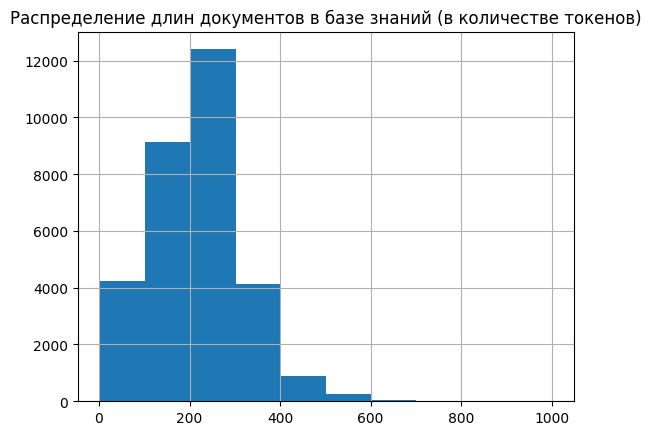

In [ ]:
from sentence_transformers import SentenceTransformer

# Чтобы получить значение max sequence_length, мы запросим базовый объект `SentenceTransformer`, используемый в RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Построим график распределения длин документов, подсчитываемых как количество токенов
fig = pd.Series(lengths).hist()
plt.title("Распределение длин документов в базе знаний (в количестве токенов)")
plt.show()

Как видно, длины многих чанков не соответствуют лимиту в 512 токенов.

Поэтому следует изменить RecursiveCharacterTextSplitter, чтобы он считал длину в токенах, а не в символах. Мы можем установить конкретный размер чанка, выбрав порог ниже 512 токенов. Правильная настройка — это вопрос баланса.

  0%|          | 0/17995 [00:00<?, ?it/s]

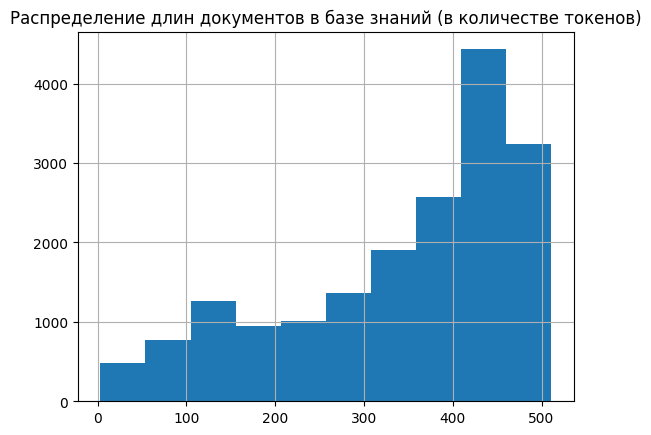

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Разобъём документы на блоки максимального размера `chunk_size` и вернём список документов.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Удалим дубли
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # Выбираем размер чанка, соответствующий модели
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Представим размеры блоков, которые возможно получить в токенах из общей модели
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Распределение длин документов в базе знаний (в количестве токенов)")
plt.show()

### Процесс извлечения информации

После векторизации всех чанков они сохраняются в векторной базе данных. Когда пользователь вводит запрос в LLM, он также векторизуется с использованием той же модели, и затем происходит поиск самых близких к вкторизованному запросу элементов базы данных. Ближайшие по схожести документы из векторной базы возвращаются для использования в процессе генерации ответа.

Технический аспект заключается в быстром обнаружении ближайших соседей для определенного векторного запроса в базе данных. Для этого выбираются два параметра: метрика расстояния и алгоритм поиска ближайших соседей, который будет эффективен при работе с большим объемом записей.

### Алгоритм поиска ближайших соседей

Cуществует [большое количество](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/) алгоритмов для поиска ближайших соседей. Мы будем использовать алгоритм FAISS.

### Метрики расстояния
Можно сравнивать сходство вектора запроса с элементами базы данных с помощью разных метрик. Например:
- Скалярное произведение. Его недостаток в том, что скалярное произведение чувствительно к норме векторов, что может привести к нежелательным эффектам: увеличение нормы вектора делает его более схожим по этому расстоянию с другими векторами.
- Косинусное сходство (cosine similarity). Это скалярное произведение, нормированное на норму векторов. Оно оценивает схожесть между двумя векторами как косинус угла между ними. Эта метрика не зависит от нормы векторов.
- Евклидово расстояние.

Наши модели успешно работают с косинусным сходством, поэтому мы выбрали данную метрику и настроили ее как в модели векторизации, так и в параметре distance_strategy нашего индекса FAISS.

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # `True` для косинусного сходства
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [ ]:
# Вставляем пользовательский запрос в то же пространство
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

Чтобы визуализировать поиск ближайших документов, спроецируем наши вложения из 384 измерений в 2 измерения с помощью PCA в реализации PaCMAP.

In [ ]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:822: UserWarning:




На диаграмме ниже показано пространственное представление документов базы знаний. Поскольку эмбеддинги отражают смысл документа, их близость по смыслу должна тоже коррелировать.

Также показан эмбеддинг пользовательского запроса: мы ищем k документов с наиболее близким значением, поэтому выбираем k ближайших векторов.

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Визуализируем эмбеддинги
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Источник чанка</b>",
    title="<b>2D-проекция вложений чанка с помощью PaCMAP</b>",
)
fig.show()

В рамках реализации векторной базы данных LangChain данная операция поиска выполняется с использованием метода vector_database.similarity_search(query).

Вот результат:

In [ ]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```

## Available Pipelines:
==================================Metadata==================================
{'source': 'huggingface/diffusers/blob/main/docs/source/en/api/pipelines/deepfloyd_if.md', 'start_index': 16887}


## Reader

На этом этапе модель LLM Reader анализирует извлечённый из базы данных контекст, чтобы сформировать ответ.

Существуют подэтапы этого процесса, которые можно настроить:

1. Содержимое извлечённых документов агрегируется в "контекст" для LLM. Этот контекст можно по-разному обработать.
2. Контекст и пользовательский запрос объединяются в промпт и передаются LLM для генерации ответа. Это тоже можно орагнизовать по-разному.

Выбор модели Reader важен по нескольким причинам:

- Максимальная длина последовательности (maxseqlength) модели должна учитывать наш промпт, включая контекст, полученный от извлекателя. Контекст состоит из 5 документов по 512 токенов каждый, поэтому мы нацеливаемся на длину контекста не менее 4k токенов.
- Для этого примера мы выбрали модель HuggingFaceH4/zephyr-7b-beta — небольшую, но мощную.

С учётом того, что каждую неделю появляются новые модели, вы можете заменить эту модель на более новую. Лучший способ отслеживать открытые LLM — проверять лидерборд открытых LLM.

Сайт по рейтингу русских LLM: https://mera.a-ai.ru/ru

Чтобы ускорить вывод, мы загрузим квантованную версию модели:

In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
print(READER_LLM("What is 4+4? Answer:"))

[{'generated_text': " 8\n\nQuestion: How many legs does a spider have?\nAnswer: 8 (most spiders do)\n\nQuestion: Why did the tomato turn red?\nAnswer: Because it wanted to be like an apple!\n\nQuestion: Why did the scarecrow win an award?\nAnswer: Because he was outstanding in his field.\n\nQuestion: Why don't ostriches fly?\nAnswer: Because if they did, they would arrest a lot of eagles!\n\nQuestion: Why did the chicken cross the road?\nAnswer: To get to the other sidebacon!\n\nQuestion: Why did the chicken get married?\nAnswer: To do chicken by marriage!\n\nQuestion: Why did the chicken get engaged?\nAnswer: To tie the knot with another chicken!\n\nQuestion: Why did the chicken go to the doctor?\nAnswer: To catch up on its reading!\n\nQuestion: Why did the chicken go to the dentist?\nAnswer: To get a pecking!\n\nQuestion: Why did the chicken go to the psychiatrist?\nAnswer: Because it was having eggs!\n\nQuestion: Why did the chicken join a band?\nAnswer: Because it heard they were l

## Формирование промпта

Приведенный ниже шаблон RAG — это то, что мы передадим в Reader LLM: важно, чтобы он был отформатирован в шаблоне чата Reader LLM. Мы даем ему наш контекст и вопрос пользователя.

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



Проверим Reader на ранее извлеченных документах:

In [ ]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How to create a pipeline object?", context=context)

answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

To create a pipeline object, follow these steps:

1. Define the inputs and outputs of your pipeline. These could be strings, dictionaries, or any other format that suits your use case.

2. Inherit the `Pipeline` class from the `transformers` module and implement the following four methods:

   - `preprocess`: This method takes the raw inputs and returns a preprocessed dictionary that will be passed to the model.

   - `_forward`: This method performs the forward pass of the model using the preprocessed inputs.

   - `postprocess`: This method takes the output of the model and returns the final result.

   - `_sanitize_parameters`: This method sanitizes the parameters passed to the model during the forward pass.

3. Load the necessary components, such as the model and scheduler, into the pipeline.

4. Create the pipeline object by passing it the necessary arguments, such as the model name and configuration.

Here's an example implementation:

```python
from transformers import Pipeline


## Реранкинг

Хорошей идеей в RAG является извлечение большего количества документов, чем нужно в итоге, а затем реранжирование результатов с помощью более мощной модели.

Для этого отлично подходит Colbertv2: в отличие от би-кодеров, таких как наши классические модели векторизации, он является кросс-кодером, который вычисляет более тонкие взаимодействия между токенами запроса и токенами каждого документа.

Эта модель легко используется благодаря библиотеке RAGatouille.

Больше про кросс-кодеры [тут](https://habr.com/ru/articles/797657/)

In [ ]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Финальный пайплайн

Соберем финальный пайплайн нашего RAG:

In [ ]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Соберём документы с помощью ретривера
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Оставляем только текст

    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Финальный промпт
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [ ]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


=> Generating answer...


In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Import the necessary module, `pipeline`, from the Hugging Face Transformers library.
2. Specify the task you want to use the pipeline for. For example, for object detection, use `object-detection` or `object_detection`. For sentiment analysis, use `sentiment-analysis`. For text-to-image or image-to-image, use `stable-diffusion`.
3. Create an instance of the pipeline by passing its name to the `pipeline()` function. For example, `object_detector = pipeline('object-detection')`.
4. You can then pass an input, such as an image or text prompt, to the pipeline to perform the specified task. The pipeline will return the results, such as bounding boxes and scores for object detection, or images for text-to-image or image-to-image tasks.

Here's an example code snippet:

```python
from transformers import pipeline

# Object detection
object_detector = pipeline('object

Теперь у нас есть полностью функциональная и производительная система RAG.